<div class="alert alert-info">
    <h1 align="center"> Persian Image Captioning</h1>
    <h3 align="center">Deep Learning in Python (HamYad Lab.)</h3>
    <h5 align="center"><a href="http://www.snrazavi.ir">Seyed Naser RAZAVI</a></h5>
</div>

## Image Captioning

- Input: image.
- Output: A sequence of words in a natural language, which hopefully describes the contents of the input Image.

<img src='imgs/image-caption-intro.png' width='80%'/>

## Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from IPython.display import display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence

import torchvision.transforms as transforms
import torchvision.models as models

from utils import *
from build_vocab import build_vocab
from data_loader import get_loader

# setup
use_gpu = torch.cuda.is_available()

### Helper functions

In [2]:
def load_cnn_model(model_name, pretrained=True):
    "Load and return a convolutional neural network."
    assert model_name in ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']
    return models.__dict__[model_name](pretrained)


def load_image(image_path, transform=None):
    "Load an image and perform given transformations."
    image = Image.open(image_path)    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image

## Data

- [Microsoft COCO Dataset](http://cocodataset.org/#captions-2015)
- More than 80k training images and 40k validation images.
- At leat 5 captions for every image.

<img src='imgs/coco-dataset-caption.png' width='65%'/>

### Load Images and Captions Data

In [3]:
dataset = load_json('data/fa_images_captions_train.json')

In [4]:
print(dataset.keys())

dict_keys(['images', 'annotations'])


In [5]:
print(dataset['images'][0])

{'file_name': '1305564994_00513f9a5b.jpg', 'id': 1305564994, 'flickr_url': 'http://www.flickr.com/photos/suzukiman/1305564994/'}


In [6]:
print(dataset['annotations'][0])

{'image_id': 1305564994, 'caption': 'مردی که لباس مسابقه ای بر تن دارد ، تایر موتور مسابقه دهندگان دیگر را بررسی می کند .', 'id': 10001, 'file_name': '1305564994_00513f9a5b.jpg'}


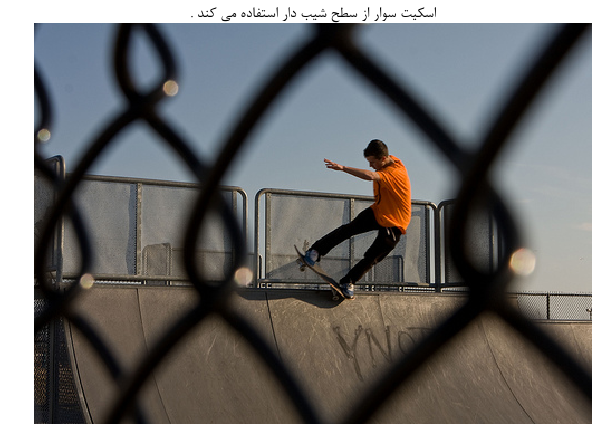

In [7]:
show_random_image_with_caption(dataset)

### Building vocabulary

In [8]:
DATA_DIR = 'data'
captions_filename = f'{DATA_DIR}/fa_captions.txt'
vocab_filename = f'{DATA_DIR}/vocab.pkl'

if os.path.exists(vocab_filename):
    vocab = pickle.load(open(vocab_filename, 'rb'))
else:
    vocab = build_vocab(captions_filename, min_count=3)
    pickle.dump(vocab, open(vocab_filename, 'wb'))

In [9]:
print(len(vocab))

1863


In [10]:
for i in range(20):
    print("%s --> %d" %(vocab.idx2word[i], i))

<PAD> --> 0
<BOS> --> 1
<EOS> --> 2
<UNK> --> 3
. --> 4
  --> 5
می --> 6
یک --> 7
در --> 8
با --> 9
و --> 10
است --> 11
روی --> 12
که --> 13
از --> 14
کند --> 15
را --> 16
به --> 17
، --> 18
مرد --> 19


### Data loader

In [11]:
images_dir = f'{DATA_DIR}/images'
captions_json = f'{DATA_DIR}/fa_images_captions_train.json'
image_size = 256
crop_size  = 224
batch_size = 16


transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

In [12]:
data_loader = get_loader(images_dir, captions_json, vocab, 
                         transform, batch_size, 
                         shuffle=True, num_workers=0)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [13]:
imgs, caps, lengths = next(iter(data_loader))

print(" ".join([str(id) for id in caps[0][1:-1]]))
print(" ".join([vocab.idx2word[id] for id in caps[0][1:-1]]))

7 35 97 9 26 138 10 579 3 48 18 114 47 73 16 17 538 3 8 88 92 11 5 4
یک دختر جوان با لباس شنا و موها <UNK> شده ، دست ها خود را به شکل <UNK> در نگه داشته است   .


In [1]:
imgs.size()

NameError: name 'imgs' is not defined

In [ ]:
print(caps.size())

## Model

<img src="imgs/enc-dec-arch.png" width="90%"/>

### Encoder (CNN)

In [14]:
class EncoderCNN(nn.Module):
    def __init__(self, model_name, embed_size):
        super(EncoderCNN, self).__init__()
        
        # load cnn and remove last layer
        cnn = load_cnn_model(model_name)
        modules = list(cnn.children())[:-1]  # remove last layer
        
        self.cnn = nn.Sequential(*modules)
        self.linear = nn.Linear(cnn.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        self.init_weights()
                
    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.02)
        self.linear.bias.data.fill_(0)
        
    def forward(self, x):
        x = self.cnn(x)  # extract features from input image
        x = Variable(x.data)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = self.bn(x)
        return x
    
    def fine_tune(self, requires_grad=True):
        for param in self.cnn.layer4.parameters():
            param.requires_grad = requires_grad

### Decoder (LSTM)

In [15]:
class DecoderLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout, tie_weights):
        super(DecoderLSTM, self).__init__()
        
        if tie_weights:
            embed_size = hidden_size
            
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.35)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(p=dropout)
        
        if tie_weights:
            # share weights between embedding and classification layer
            self.fc.weight = self.embedding.weight
            
        self.init_weights()
        
    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        
    def forward(self, features, captions, lengths):
        x = self.embedding(captions)
        x = torch.cat([features.unsqueeze(1), x], dim=1)
        x = self.dropout(x)
        x = pack_padded_sequence(x, lengths, batch_first=True)
        x, _ = self.lstm(x)
        x = self.dropout(x[0])
        x = self.fc(x)
        return x
    
    def sample(self, features, states=None):
        """Samples captions for given image features (Greedy search)."""
        sampled_ids = []
        inputs = features.unsqueeze(1)

        for i in range(20):                                      # maximum sampling length
            hiddens, states = self.lstm(inputs, states)          # (batch_size, 1, hidden_size), 
            outputs = self.fc(hiddens.squeeze(1))                # (batch_size, vocab_size)
            token_id = outputs.max(1)[1]
            sampled_ids += [token_id]
            inputs = self.embedding(token_id)
            inputs = inputs.unsqueeze(1)                         # (batch_size, 1, embed_size)
        sampled_ids = torch.cat(sampled_ids, 0)                  # (batch_size, 20)
        return sampled_ids.squeeze()

### Encoder-Decoder

In [16]:
class EncoderDecoder(nn.Module):
    
    def __init__(self, cnn_name, vocab_size, embed_size, hidden_size, num_layers, dropout, tie_weights):
        super(EncoderDecoder, self).__init__()
        
        if tie_weights:
            embed_size = hidden_size
            
        self.encoder = EncoderCNN(cnn_name, embed_size)
        self.decoder = DecoderLSTM(vocab_size, embed_size, hidden_size, num_layers, dropout, tie_weights)
        
        # create output folder to save weights
        self.save_path = f'{cnn_name}-{embed_size}-{hidden_size}-{num_layers}'
        if not os.path.exists(self.save_path):
            os.mkdir(self.save_path)
    
    def forward(self, images, captions, lengths):
        features = self.encoder(images)
        outputs = self.decoder(features, captions, lengths)
        return outputs
    
    def save(self, epoch, loss):
        torch.save({'encoder': self.encoder.state_dict(), 
                    'decoder': self.decoder.state_dict()}, f'{self.save_path}/{epoch}-{loss:.2f}.pth')
    
    def load(self, epoch):
        model_path = glob(f'{self.save_path}/{epoch}-*.pth')[-1]
        try:
            d = torch.load(model_path)
            self.encoder.load_state_dict(d['encoder'])
            self.decoder.load_state_dict(d['decoder'])
        except:
            print('Invalid epoch number <{}>, the model does not exist!'.format(epoch))

### Parameters

In [17]:
# model hyper-parameters
cnn_name = 'resnet50'
embed_size  = 512
hidden_size = 512
num_layers  = 2
tie_weights = True

# training hyper-parameters
start_epoch = 0
num_epochs  = 20
learning_rate = 0.001

## Training

In [18]:
def train_epoch(model, train_dl, criterion, optimizer, scheduler, epoch, last_epoch):
    model.encoder.train()
    model.decoder.train()
    scheduler.step()
    
    total_steps = len(train_dl)
    epoch_loss = 0.0
    
    for i, (images, captions, lengths) in enumerate(train_dl):
        images, captions = to_var(images), to_var(captions)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        
        # forward step
        outputs = model(images, captions, lengths)
        loss = criterion(outputs, targets)
        epoch_loss = (epoch_loss * i + loss.data[0]) / (i + 1)
        
        # backward step
        model.encoder.zero_grad()
        model.decoder.zero_grad()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.decoder.parameters(), 5.0)
        optimizer.step()
        
        # report log info
        sys.stdout.flush()
        sys.stdout.write('\rEpoch [%2d/%2d], Step [%3d/%3d], Loss = %.4f, Perplexity = %.4f    '
                         % (epoch+1, last_epoch, i+1, total_steps, epoch_loss, np.exp(epoch_loss)))
    print()

    return epoch_loss


def train(model, train_dl, criterion, optimizer, scheduler, start_epoch=0, num_epochs=10):
    last_epoch = start_epoch + num_epochs
        
    for epoch in range(start_epoch, last_epoch):                
        # train step
        trn_loss = train_epoch(model, data_loader, criterion, optimizer, scheduler, epoch, last_epoch)
        
        # save model
        model.save(epoch, trn_loss)

### Encoder-Decoder

In [19]:
model = EncoderDecoder(cnn_name, len(vocab), embed_size, hidden_size, num_layers, 0.3, tie_weights)
if use_gpu:
    model = model.cuda()

### Loss and optimizer

In [20]:
# loss function
criterion = nn.CrossEntropyLoss()
if use_gpu:
    criterion = criterion.cuda()
    
# list of parameters which will be updated
params = list(model.decoder.parameters())
params += list(model.encoder.linear.parameters()) 
params += list(model.encoder.bn.parameters())

# optimizer
optimizer = torch.optim.RMSprop(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)

### Training

In [21]:
train(model, data_loader, criterion, optimizer, scheduler, start_epoch, num_epochs)

Epoch [ 1/20], Step [674/674], Loss = 3.4410, Perplexity = 31.2180      
Epoch [ 2/20], Step [674/674], Loss = 2.6980, Perplexity = 14.8495    
Epoch [ 3/20], Step [674/674], Loss = 2.4370, Perplexity = 11.4389    
Epoch [ 4/20], Step [674/674], Loss = 2.2681, Perplexity = 9.6607    
Epoch [ 5/20], Step [674/674], Loss = 2.1472, Perplexity = 8.5610    
Epoch [ 6/20], Step [674/674], Loss = 2.0411, Perplexity = 7.6994    
Epoch [ 7/20], Step [674/674], Loss = 1.9525, Perplexity = 7.0460    
Epoch [ 8/20], Step [674/674], Loss = 1.8705, Perplexity = 6.4918    
Epoch [ 9/20], Step [674/674], Loss = 1.7992, Perplexity = 6.0446    
Epoch [10/20], Step [674/674], Loss = 1.7351, Perplexity = 5.6695    
Epoch [11/20], Step [674/674], Loss = 1.6762, Perplexity = 5.3452    
Epoch [12/20], Step [674/674], Loss = 1.6214, Perplexity = 5.0600    
Epoch [13/20], Step [674/674], Loss = 1.5715, Perplexity = 4.8139    
Epoch [14/20], Step [674/674], Loss = 1.5205, Perplexity = 4.5743    
Epoch [15/20], 

## Sampling: generate captions

In [25]:
from PIL import Image

val_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

In [26]:
def generate_caption(model, img_filenames):
    model.encoder.eval()
    model.decoder.eval()
    
    captions = []
    
    for img_filename in img_filenames:

        # prepare test image
        image = load_image(img_filename, val_transform)
        image_tensor = to_var(image, volatile=True)

        # Generate features from image
        feature = model.encoder(image_tensor)

        # Generate caption from image
        sampled_ids = model.decoder.sample(feature)
        sampled_ids = sampled_ids.cpu().data.numpy()

        # decode word ids to words
        sampled_caption = []
        for word_id in sampled_ids:
            word = vocab.idx2word[word_id]
            if word == '<EOS>': break
            sampled_caption.append(word)

        caption = " ".join(sampled_caption[1:])
        captions.append((img_filename, caption))
    
    return captions

In [27]:
img_filenames = glob('data/images/*.jpg')[:10]
captions = generate_caption(model, img_filenames)

for img, caption in captions:
    display(show_persian_image_and_caption(caption, img))

In [28]:
img_filenames = glob('./data/im2txt/*.jpg')[:10]
captions = generate_caption(model, img_filenames)

for img, caption in captions:
    display(show_persian_image_and_caption(caption, img))

## Possible Improvements

- Using a larger dataset
- Using pre-trained word vectors
- Using a BiLSTM
- Increasing depth of LSTM
- Using Attention mechanism
- Using Beam Search instead of Greedy Search
- Fine Tuning last layers of CNN.